<a href="https://colab.research.google.com/github/filzahms/DeepLearningM3/blob/main/Jewelry_filzah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download filzahsalsabila/perhiasan-dataset

 68% 17.0M/24.9M [00:00<00:00, 66.4MB/s]
100% 24.9M/24.9M [00:00<00:00, 74.0MB/s]


In [5]:
!mkdir perhiasan-dataset

In [6]:
!unzip /content/perhiasan-dataset.zip -d /content/perhiasan-dataset

Archive:  /content/perhiasan-dataset.zip
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Bracelet (1).jpg  
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Bracelet (10).jpg  
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Bracelet (11).jpg  
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Bracelet (12).jpg  
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Bracelet (13).jpg  
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Bracelet (2).jpg  
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Bracelet (24).jpg  
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Bracelet (25).jpg  
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Bracelet (26).jpg  
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Bracelet (27).jpg  
  inflating: /content/perhiasan-dataset/Jewelry_Images/test/Bracelet/Br

In [7]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [8]:
dataset_path = Path(r'/content/perhiasan-dataset')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [9]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/perhiasan-dataset/Jewelry_Images/test...,Necklace
1,/content/perhiasan-dataset/Jewelry_Images/test...,Necklace
2,/content/perhiasan-dataset/Jewelry_Images/test...,Necklace
3,/content/perhiasan-dataset/Jewelry_Images/test...,Necklace
4,/content/perhiasan-dataset/Jewelry_Images/test...,Necklace


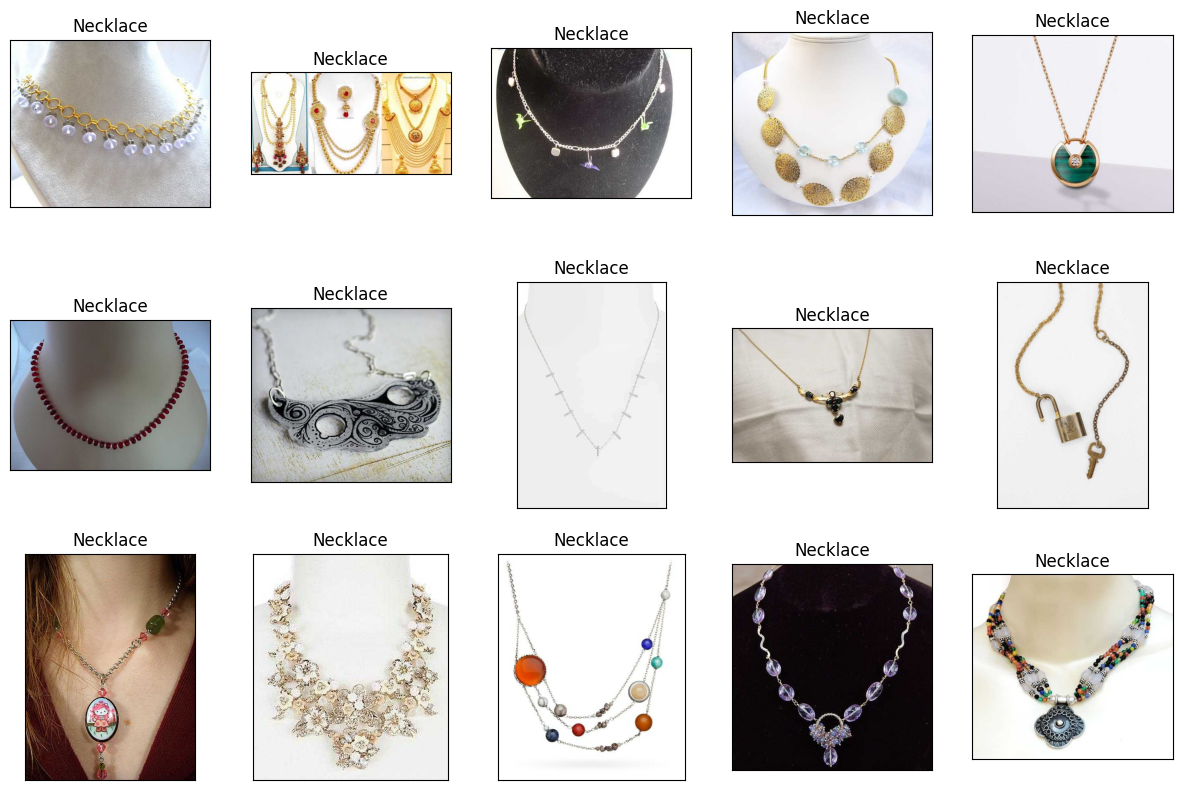

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [11]:
df.label.value_counts()

Necklace    251
Ring        251
Bracelet    251
Name: label, dtype: int64

In [12]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Necklace    251
Ring        251
Bracelet    251
Name: label, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [15]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (421, 2)
Shape of test data (226, 2)
Shape of validation data (106, 2)


In [16]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 421 validated image filenames belonging to 3 classes.
Found 226 validated image filenames belonging to 3 classes.
Found 106 validated image filenames belonging to 3 classes.


In [17]:
input_shape = (200, 200, 3)

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [38]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size=64, validation_data=val, epochs=300, callbacks=callback)

Epoch 1/300
14/14 [==============================] - 10s 544ms/step - loss: 0.5263 - accuracy: 0.7886 - val_loss: 0.7849 - val_accuracy: 0.7170
Epoch 2/300
14/14 [==============================] - 6s 450ms/step - loss: 0.5159 - accuracy: 0.7981 - val_loss: 0.6759 - val_accuracy: 0.7358
Epoch 3/300
14/14 [==============================] - 7s 520ms/step - loss: 0.4520 - accuracy: 0.8195 - val_loss: 0.6026 - val_accuracy: 0.7264
Epoch 4/300
14/14 [==============================] - 7s 523ms/step - loss: 0.4561 - accuracy: 0.8195 - val_loss: 0.7146 - val_accuracy: 0.7358
Epoch 5/300
14/14 [==============================] - 6s 450ms/step - loss: 0.4873 - accuracy: 0.8147 - val_loss: 0.8215 - val_accuracy: 0.6981
Epoch 6/300
14/14 [==============================] - 7s 525ms/step - loss: 0.5211 - accuracy: 0.8005 - val_loss: 0.6030 - val_accuracy: 0.7264
Epoch 7/300
14/14 [==============================] - 6s 448ms/step - loss: 0.4139 - accuracy: 0.8385 - val_loss: 0.7404 - val_accuracy: 0.792

In [39]:
model.save('model-1.h5')

In [40]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

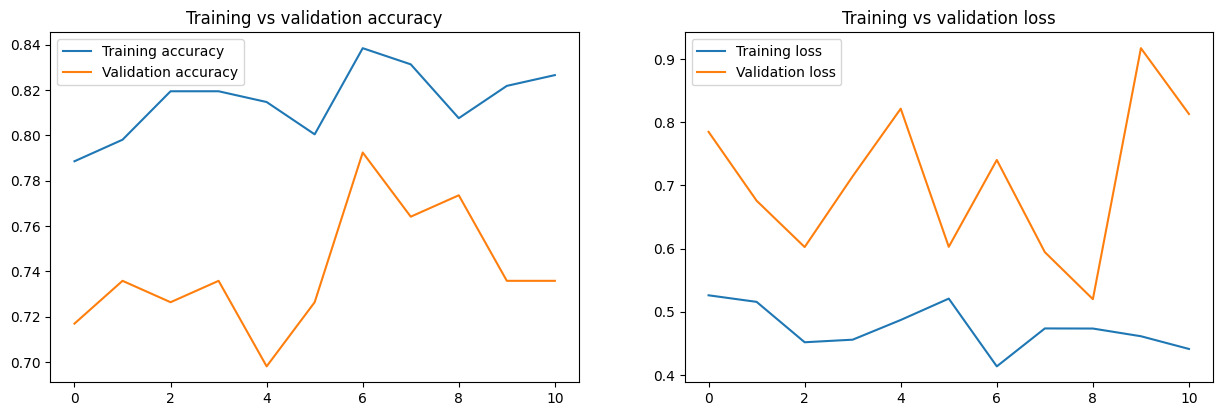

In [41]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [42]:
pred = model.predict(test)

8/8 [==============================] - 3s 350ms/step


In [43]:
pred = np.argmax(pred, axis=1)

In [44]:
labels = train.class_indices

In [45]:
labels

{'Bracelet': 0, 'Necklace': 1, 'Ring': 2}

In [46]:
labels = dict((v,k) for k, v in labels.items())

In [47]:
labels

{0: 'Bracelet', 1: 'Necklace', 2: 'Ring'}

In [48]:
y_pred = [labels[k] for k in pred]

In [49]:
print(classification_report(x_test.label, y_pred))

              precision    recall  f1-score   support

    Bracelet       0.79      0.53      0.64        86
    Necklace       0.71      0.80      0.75        71
        Ring       0.65      0.83      0.73        69

    accuracy                           0.71       226
   macro avg       0.72      0.72      0.71       226
weighted avg       0.72      0.71      0.70       226



In [50]:
print(confusion_matrix(x_test.label, y_pred))

[[46 14 26]
 [ 9 57  5]
 [ 3  9 57]]


In [51]:
test_accuracy = model.evaluate(test)[1]

8/8 [==============================] - 4s 457ms/step - loss: 0.8612 - accuracy: 0.6947
